In [1]:
# 시각화 시, 한글 깨짐 문제 해결 - 나눔폰트 설치 후, 런타임 재시작
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (8,112 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155013 files and d

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings(action='ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
os.chdir("/content/drive/MyDrive/암빅데이터_경진대회/최종코드")

## 대장암 데이터

### [1] 데이터 로드

#### Train-set, Test-set 설정

In [4]:
colorectal_train = pd.read_csv("./data/original/학습데이터_대장암.csv")
colorectal_train

,No,AGE,mucinous,signet ring cell,adenocarcinoma,carcinoide tumor,Neuroendocrine carcinoma,squamous cell carcinoma,Neoplasm malignant,Tis,T1,T1a,T1b,T1c,T2,T2a,T2b,T2C,T3,T3a,T3b,T4,T4a,T4b,N1,N1a,N1b,N1c,N2,N2a,N2b,N2c,N3,N3a,N3b,M1,M1a,M1b,M1c,Type of Drink,Smoke,Height,Weight,EGFR,MSI,KRASMUTATION_EXON2,KRASMUTATION,NRASMUTATION,BRAF_MUTATION,Operation,Chemotherapy,Radiation Therapy,Death,Survival period
0,0,30,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,3,0,141.0,73.2,99,2,99,99,1,99,1,0,1,1,487
1,1,67,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,168.1,64.5,99,2,1,99,99,99,1,0,0,0,198
2,2,58,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,99,0,166.0,77.5,99,99,99,2,99,99,1,0,0,0,238
3,3,79,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,99,0,144.9,61.0,2,99,99,99,99,99,0,1,1,0,18
4,4,67,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,99,0,169.5,52.2,2,99,99,1,99,99,1,0,0,0,123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,73,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,146.2,89.0,99,99,99,99,99,99,1,0,1,1,1374
9996,9996,60,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,99,0,169.4,56.9,99,99,99,99,1,99,1,0,0,0,30
9997,9997,26,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,168.0,59.3,99,99,99,99,99,99,1,1,0,1,1756
9998,9998,60,0,0,1,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,99,0,149.6,61.5,99,99,99,99,1,99,0,1,0,0,72


In [5]:
colorectal_test = pd.read_csv("./data/original/대장암 합성데이터.csv")
colorectal_test

,No,AGE,mucinous,signet ring cell,adenocarcinoma,carcinoide tumor,Neuroendocrine carcinoma,squamous cell carcinoma,Neoplasm malignant,Tis,T1,T1a,T1b,T1c,T2,T2a,T2b,T2C,T3,T3a,T3b,T4,T4a,T4b,N1,N1a,N1b,N1c,N2,N2a,N2b,N2c,N3,N3a,N3b,M1,M1a,M1b,M1c,Type of Drink,Smoke,Height,Weight,EGFR,MSI,KRASMUTATION_EXON2,KRASMUTATION,NRASMUTATION,BRAF_MUTATION,Operation,Chemotherapy,Radiation Therapy,Death,Survival period
0,0,77,0,1,1,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,99,0,164.5,38.0,99,99,99,99,99,99,1,0,1,1,161
1,1,55,0,1,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,99,2,166.0,38.0,1,99,1,2,1,99,0,0,0,0,393
2,2,48,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,1,1,173.4,60.7,1,2,99,1,1,1,1,0,0,1,821
3,3,57,0,1,1,1,1,0,0,0,0,1,0,0,0,1,1,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,99,2,155.2,67.0,99,99,1,2,1,1,1,0,1,0,587
4,4,39,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,2,0,149.6,60.8,1,1,2,2,99,99,1,0,0,0,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,59,0,0,1,1,1,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,1,0,0,99,1,151.0,44.6,99,99,2,1,1,1,1,0,0,0,1397
4996,4996,64,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,3,0,155.8,68.6,1,1,2,99,1,99,1,1,0,0,1093
4997,4997,32,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,1,2,0,160.0,74.2,99,99,99,99,99,99,0,0,1,1,69
4998,4998,75,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,1,159.9,70.0,99,99,2,99,99,99,1,0,0,1,30


In [6]:
# concatenate train + test
colorectal_total = pd.concat([colorectal_train,colorectal_test], ignore_index=True)

# 새로 Train, Test 나눠주기 전에 전체 데이터 shuffle 진행
colorectal_shuffle = colorectal_total.sample(frac=1, random_state=23).reset_index(drop=True)

#### X, y 설정  

In [7]:
# EDA에서는 주로 y를 Death, Survival period 로 두고, X를 그 외 컬럼으로 두어 분석 진행함.

# y값 : Death, Survival period 컬럼
colorectal_y = colorectal_shuffle.iloc[:,52:54]          # DataFrame
colorectal_death = colorectal_shuffle.iloc[:,52]         # Series
colorectal_survival = colorectal_shuffle.iloc[:,53]      # Series


# X값: Death, Survival period를 제외한 모든 컬럼
colorectal_x = colorectal_shuffle.drop(['Death','Survival period'],axis=1,inplace=False)      # DataFrame

### [2] 연구가설 설정  및 검증

#### 그 외 -가설1)  
병기 STAGE에 따라 수술여부, 항암제 치료여부, 방사선 치료여부가 달라질 것이다.

In [8]:
from preprocessing.stage import Preprocess, Classify

df_TNM = colorectal_x.iloc[:,9:39]
df_TNM['Stage'] = np.NaN   # Stage 열 추가 (초기값: NaN)

# 암 병기값 분류를 위해 TNM 병기 값 전처리 (예: 사용 안되는 컬럼의 값들을 유사한 컬럼에 더해주기)
df_TNM = Preprocess(df_TNM)

# 암 병기값 분류
df_TNM = Classify(df_TNM)

# df_TNM['Stage']의 NaN값을 0으로 대체
df_TNM['Stage'].fillna(0, inplace=True)

In [9]:
df_stage = pd.DataFrame()
df_stage['STAGE'] = df_TNM['Stage'].map({0:"0기", 1.0:"1기", 2.3:"2기(A)", 2.5:"2기(B)", 2.7:"2기(C)",
                                         3.3:"3기(A)", 3.5:"3기(B)", 3.7:"3기(C)", 4.0:"4기"})

df_stage['OPERATION'] = colorectal_x['Operation']          # 대장암 수술 여부
df_stage['CHEM'] = colorectal_x['Chemotherapy']            # 항암제 치료 여부
df_stage['RADIATION'] = colorectal_x['Radiation Therapy']  # 방사선 치료 여부
df_stage

,STAGE,OPERATION,CHEM,RADIATION
0,4기,1,0,1
1,4기,0,0,1
2,4기,1,0,0
3,1기,1,0,0
4,4기,0,0,0
...,...,...,...,...
14995,4기,0,0,1
14996,4기,0,0,1
14997,4기,1,0,0
14998,3기(A),1,0,1


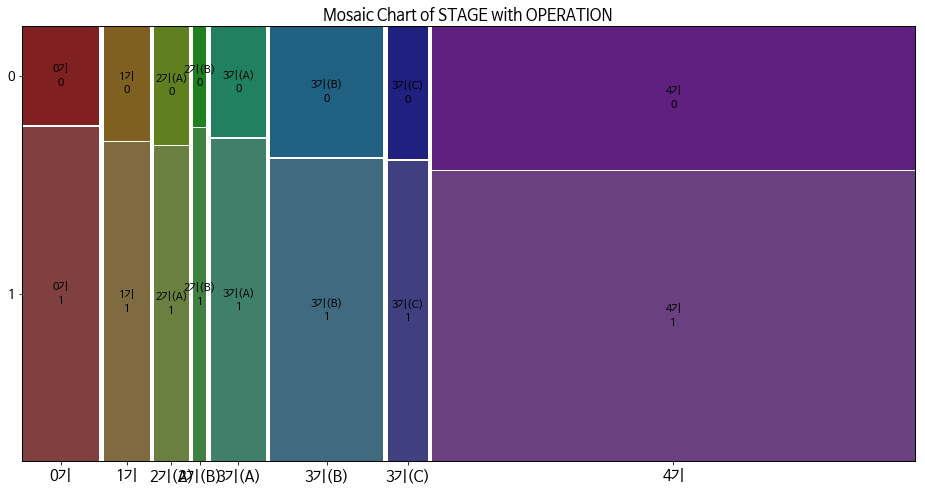

In [13]:
# 병기 STAGE에 따른 수술여부
plt.rcParams['figure.figsize'] = [16, 8]
plt.rc('font', size=13)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=13)
mosaic(df_stage.sort_values('STAGE'),['STAGE','OPERATION'],
       title = 'Mosaic Chart of STAGE with OPERATION')
plt.rc('font',family = 'NanumBarunGothic', size=14)
plt.show()
# 0:수술X,  1:수술O
# 알 수 있는 점
# 4기로 갈수록 수술을 하는 경우가 줄어듦.

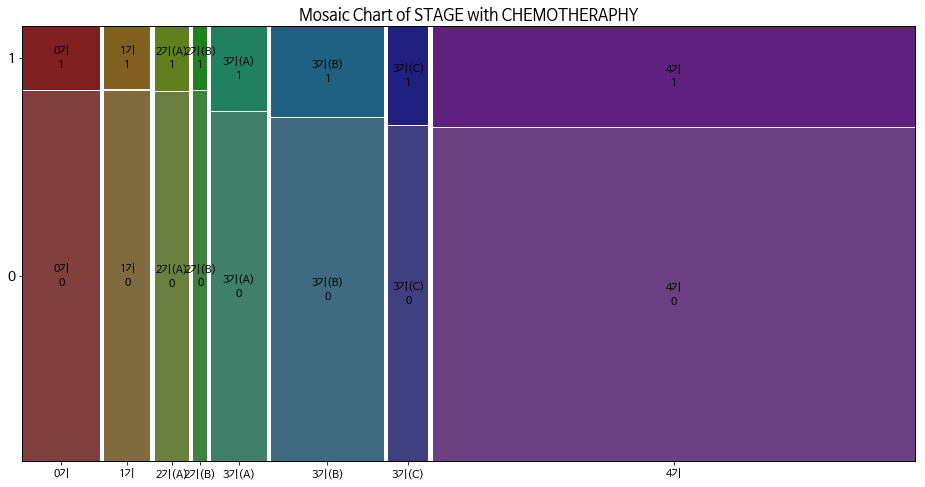

In [14]:
# 병기 STAGE에 따른 항암제 치료여부
plt.rcParams['figure.figsize'] = [16, 8]
plt.rc('font', size=13)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=14)
mosaic(df_stage.sort_values('STAGE'),['STAGE','CHEM'],
       title = 'Mosaic Chart of STAGE with CHEMOTHERAPHY')
plt.show()
# 0: 항암제 치료 X,  1: 항암제 치료 O

# 알 수 있는 점
# 4기로 갈 수록 항암제 치료를 하는 경우가 많아짐.

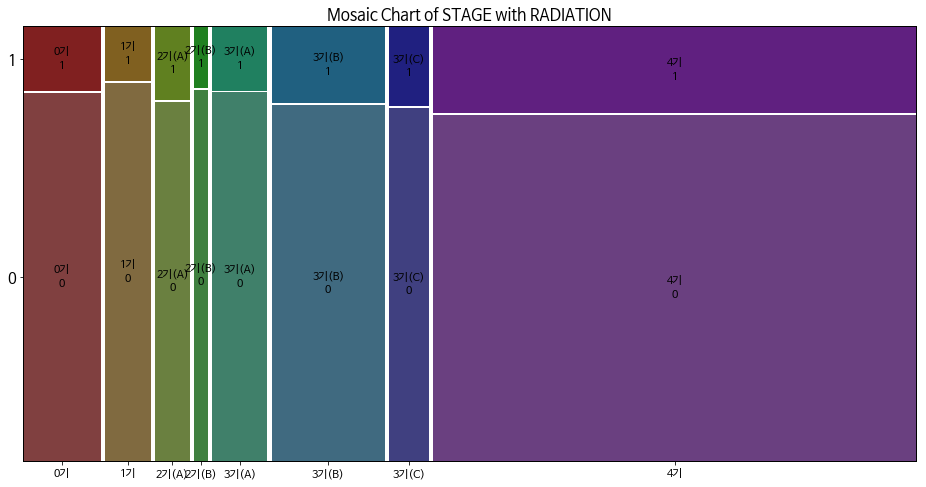

In [15]:
# 병기 STAGE에 따른 방사선 치료여부
plt.rcParams['figure.figsize'] = [16, 8]
plt.rc('font', size=13)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=15)
mosaic(df_stage.sort_values('STAGE'),['STAGE','RADIATION'],
       title = 'Mosaic Chart of STAGE with RADIATION')
plt.show()
# 0: 방사선 치료 X,  1: 방사선 치료 O

# 알 수 있는 점
# 대체로, 4기로 갈수록 방사선 치료를 많이 함.

#### 그 외-가설2) 
나이가 더 많을수록 사망인경우가 더 많을 것이고, 암 진단 후 생존일수가 더 짧을 것.

In [16]:
## AGE (Categorical화; 연속형을 범주형으로 변환)
bins = [0,20,30,40,50,60,70,80,90]
df_age = pd.DataFrame()
df_age['age_original'] = colorectal_x['AGE']
df_age['age_digitize'] = np.digitize(colorectal_x['AGE'],bins)
df_age['AGE'] = df_age['age_digitize'].map({1:'20세 미만',2:'20대',3:'30대',4:'40대',5:'50대',6:'60대',7:'70대',8:'80대',9:'90세 이상'})
df_age['SURVIVE'] = colorectal_death.map({0:"SURVIVED", 1:"DEAD"})
df_age['PERIOD'] = colorectal_survival
df_age

,age_original,age_digitize,AGE,SURVIVE,PERIOD
0,19,1,20세 미만,SURVIVED,907
1,33,3,30대,SURVIVED,420
2,58,5,50대,DEAD,441
3,61,6,60대,SURVIVED,943
4,55,5,50대,SURVIVED,262
...,...,...,...,...,...
14995,67,6,60대,SURVIVED,1551
14996,39,3,30대,SURVIVED,285
14997,81,8,80대,SURVIVED,251
14998,29,2,20대,SURVIVED,420


In [17]:
df_age.AGE.value_counts()

60대       2977
50대       2695
70대       2430
40대       2280
30대       1778
80대       1620
20대        748
20세 미만     248
90세 이상     224
Name: AGE, dtype: int64

 AGE(Numeric) - Survival period(Numeric) : 산점도 (상관계수)

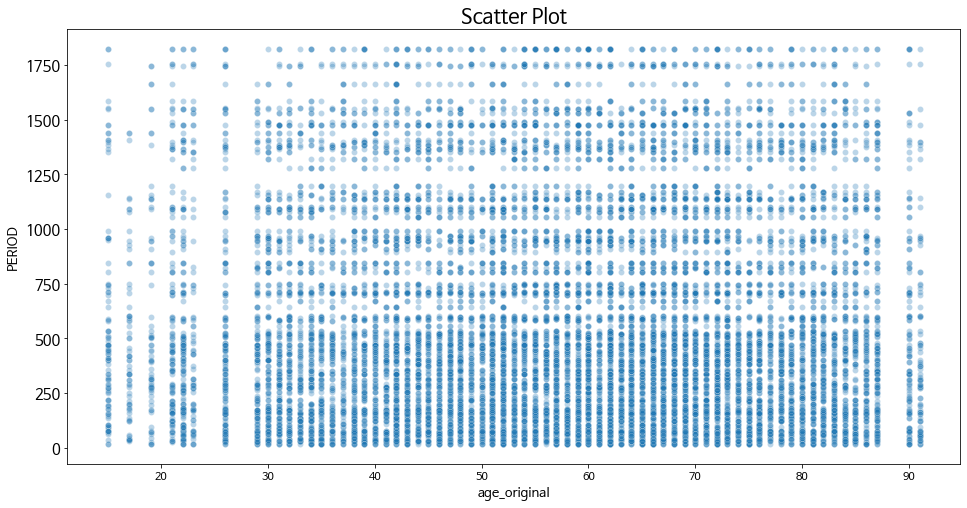

In [19]:
sns.scatterplot(x = 'age_original',
            y = 'PERIOD',
            alpha = 0.3,
            data = df_age)
plt.title('Scatter Plot',fontsize=20)
plt.show()

## 알 수 있는 점
## AGE와 Survival period는 상관관계가 없음

In [20]:
# age_original과 PERIOD 간 상관계수 구하기
corr = stats.pearsonr(df_age['age_original'], df_age['PERIOD'])
print(corr) # 왼쪽: 피어슨 상관계수, 오른쪽: p-value
# p-value > 0.05 이기 때문에 두 변수간 상관관계는 통계적으로 유의하지 않다.

(-0.007425314751768294, 0.36316626921502176)


AGE(Categorical) - Survival period(Numeric) : Box plot

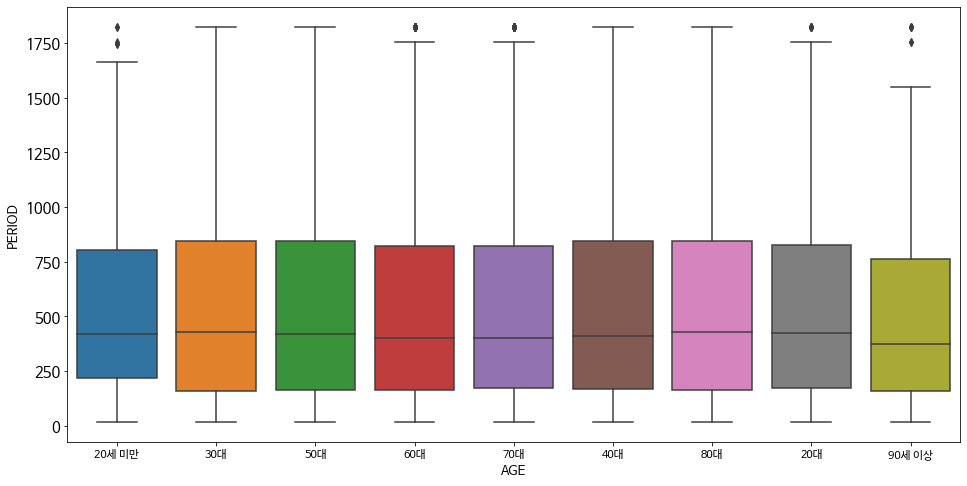

In [21]:
sns.boxplot(x="AGE",
            y="PERIOD",
            data = df_age)

In [22]:
print('20세 미만 PERIOD 평균 :', df_age[df_age['AGE']=='20세 미만']['PERIOD'].mean())
print('20대 PERIOD 평균 :',df_age[df_age['AGE']=='20대']['PERIOD'].mean())
print('30대 PERIOD 평균 :',df_age[df_age['AGE']=='30대']['PERIOD'].mean())
print('40대 PERIOD 평균 :',df_age[df_age['AGE']=='40대']['PERIOD'].mean())
print('50대 PERIOD 평균 :',df_age[df_age['AGE']=='50대']['PERIOD'].mean())
print('60대 PERIOD 평균 :',df_age[df_age['AGE']=='60대']['PERIOD'].mean())
print('70대 PERIOD 평균 :',df_age[df_age['AGE']=='70대']['PERIOD'].mean())
print('80대 PERIOD 평균 :',df_age[df_age['AGE']=='80대']['PERIOD'].mean())
print('90세 이상 PERIOD 평균 :',df_age[df_age['AGE']=='90세 이상']['PERIOD'].mean())

## 알 수 있는 점
## 70세 이상에서는 나이가 많을 수록 Survival Period가 줄어듦.

20세 미만 PERIOD 평균 : 555.5483870967741
20대 PERIOD 평균 : 557.0534759358288
30대 PERIOD 평균 : 557.218785151856
40대 PERIOD 평균 : 553.6004385964912
50대 PERIOD 평균 : 558.2597402597403
60대 PERIOD 평균 : 544.4776620759153
70대 PERIOD 평균 : 546.9971193415638
80대 PERIOD 평균 : 553.8160493827161
90세 이상 PERIOD 평균 : 526.3080357142857


#### 그 외-가설3)
BMI가 클수록 사망인 경우가 많고, 암 진단 후 생존일수가 짧을 것이다.

* BMI(체질량지수) = w/t^2   (w:몸무게(kg), t:키(m))

In [24]:
colorectal_bmi=pd.DataFrame()
colorectal_bmi['BMI']=colorectal_x['Weight']/(colorectal_x['Height']**2)
colorectal_bmi['SURVIVED']=colorectal_y['Death']
colorectal_bmi['PERIOD']=colorectal_y['Survival period']
colorectal_bmi

,BMI,SURVIVED,PERIOD
0,0.001889,0,907
1,0.002367,0,420
2,0.002143,1,441
3,0.002455,0,943
4,0.002498,0,262
...,...,...,...
14995,0.001800,0,1551
14996,0.002217,0,285
14997,0.003156,0,251
14998,0.001995,0,420


In [25]:
colorectal_bmi['BMI']=np.digitize(colorectal_bmi['BMI'],bins=[0.0023,0.0025,0.0030,0.0035])
colorectal_bmi['BMI']=colorectal_bmi['BMI'].map({0:"정상",1:"과체중",2:"비만 1단계", 3:"비만 2단계",4:"비만 3단계"})
colorectal_bmi['SURVIVED']=colorectal_bmi['SURVIVED'].map({0:"SURVIVED",1:"DEAD"})

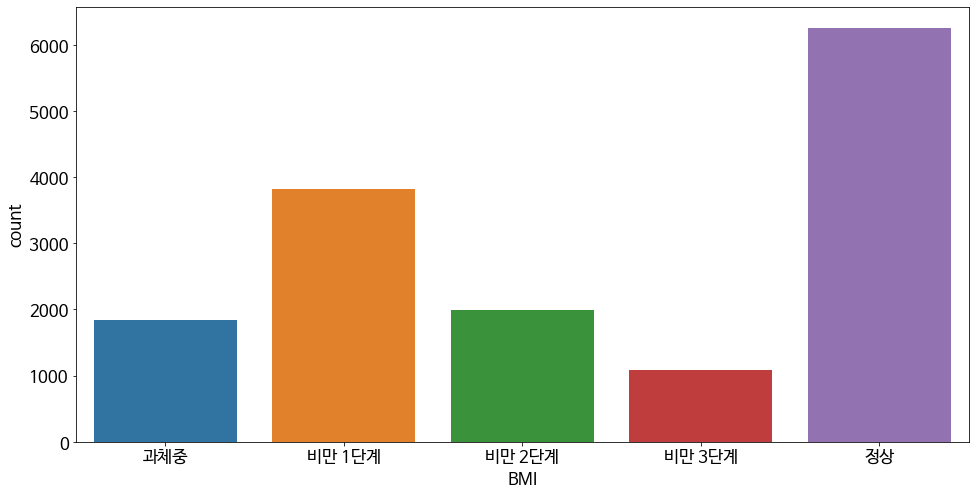

In [32]:
# BMI 값 분포 countplot
sns.countplot(data=colorectal_bmi.sort_values('BMI'),x='BMI')
plt.rc('font', size=17)
plt.rc('xtick', labelsize=17)
plt.rc('ytick', labelsize=17)
plt.show()

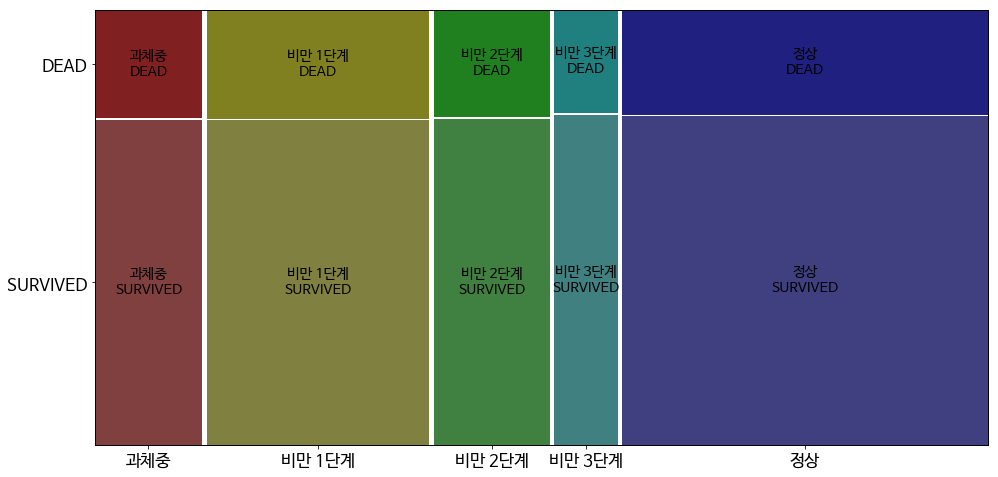

In [33]:
mosaic(colorectal_bmi.sort_values('BMI'),['BMI','SURVIVED'])
plt.show()

# 비만 초기 단계에서 후기 단계로 갈수록 사망률이 줄어듬.

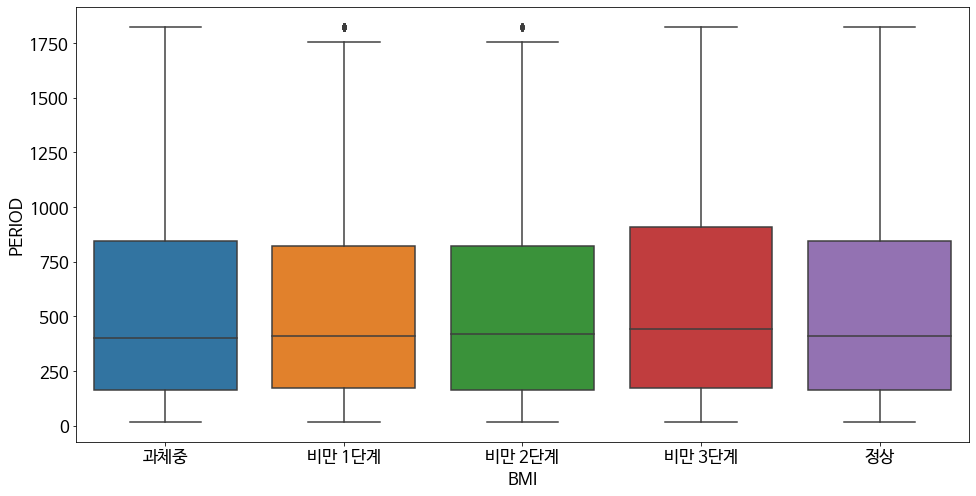

In [34]:
sns.boxplot(data=colorectal_bmi.sort_values('BMI'),x='BMI',y='PERIOD')

# 비만 3단계에서 생존기간 평균값이 가장 높음

In [48]:
df_bmi = pd.DataFrame(colorectal_x['Weight']/(colorectal_x['Height']**2))
df_bmi.columns=['BMI']

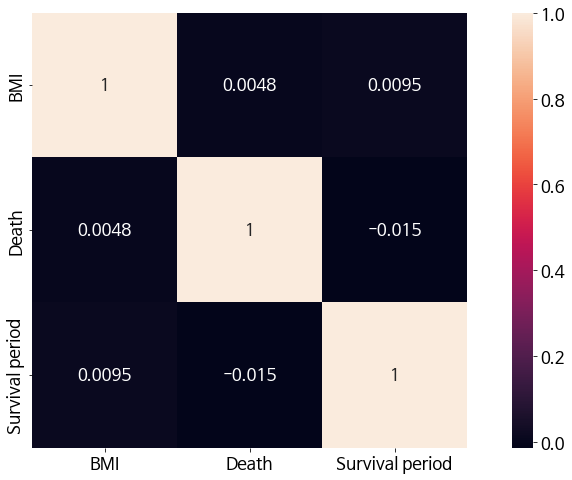

In [55]:
# BMI와 Death, Survival period 간의 상관계수
heatmap_bmi=pd.concat([df_bmi,colorectal_death,colorectal_survival],axis=1)
sns.heatmap(data=heatmap_bmi.corr(),annot=True, square=True)

In [59]:
#상관계수 검정
corr_bmi1=stats.pearsonr(df_bmi['BMI'],colorectal_death)
corr_bmi2=stats.pearsonr(df_bmi['BMI'],colorectal_survival)
print("bmi와 사망률 사이의 p-value:",corr_bmi1)
print("bmi와 생존 기간 사이의 p-value:",corr_bmi2)

#알파=0.05
#모든 p-value가 0.05보다 크므로 변수 간의 유의미한 상관관계를 갖는다고 할 수 없다.

bmi와 사망률 사이의 p-value: (0.0047554764762758415, 0.5603112228415138)
bmi와 생존 기간 사이의 p-value: (0.009456340567654433, 0.24682737786400294)
